# Advanced Contrarian Portfolio Analysis

This notebook provides comprehensive analysis of the contrarian forex portfolio strategy including:
- Parameter optimization results
- Portfolio equity curves
- Risk-adjusted performance metrics
- Advanced statistical analysis and visualizations

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our advanced modules
from modules.data_loader import ForexDataLoader
from modules.signal_generator import ConrarianSignalGenerator
from modules.backtesting_engine import BacktestingEngine
from modules.performance_analyzer import PerformanceAnalyzer
from modules.portfolio_manager import PortfolioManager
from modules.parameter_optimizer import ParameterOptimizer
from modules.results_manager import ResultsManager

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

print("🚀 ADVANCED CONTRARIAN PORTFOLIO ANALYSIS")
print("=" * 60)
print("Loading comprehensive backtesting framework...")

🚀 ADVANCED CONTRARIAN PORTFOLIO ANALYSIS
Loading comprehensive backtesting framework...


## 1. Data Setup and Configuration

In [2]:
# Initialize all components
data_loader = ForexDataLoader('../data')
results_manager = ResultsManager('../results')

# Load forex data
print("📈 Loading forex market data...")
prices = data_loader.load_unified_prices()
returns = data_loader.load_unified_returns()

print(f"✅ Loaded {len(prices.columns)} currency pairs")
print(f"📅 Data period: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print(f"📊 Total trading days: {len(prices):,}")

# Display currency universe
print("\n💱 Currency Universe:")
for i, pair in enumerate(prices.columns, 1):
    print(f"{i:2d}. {pair.replace('_X', '')}")

📈 Loading forex market data...
✅ Loaded 20 currency pairs
📅 Data period: 2000-01-03 to 2025-08-05
📊 Total trading days: 6,677

💱 Currency Universe:
 1. EURUSD
 2. GBPUSD
 3. USDJPY
 4. USDCHF
 5. AUDUSD
 6. USDCAD
 7. NZDUSD
 8. EURGBP
 9. EURJPY
10. EURCHF
11. EURAUD
12. EURCAD
13. EURNZD
14. GBPJPY
15. GBPCHF
16. GBPAUD
17. GBPCAD
18. GBPNZD
19. AUDJPY
20. AUDCHF


## 2. Parameter Optimization Analysis

In [3]:
# Define parameter grid for optimization
parameter_grid = {
    'n_worst_performers': [2, 3, 5, 7, 10],  # N values as specified
    'lookback_days': [1,2,35, 10, 15, 20, 30,40,60,90]     # M values as specified
}

# Configure transaction costs for optimization (in basis points)
TRANSACTION_COST_BPS = 0.0  # 0 bps = 0.00% per trade - MODIFY THIS VALUE AS NEEDED

print("🔍 Starting comprehensive parameter optimization...")
print(f"Testing {len(parameter_grid['n_worst_performers']) * len(parameter_grid['lookback_days'])} combinations")
print(f"💰 Transaction Cost: {TRANSACTION_COST_BPS} bps ({TRANSACTION_COST_BPS/100:.3f}%) per trade")

# Manual optimization implementation to avoid multiprocessing issues
from itertools import product
from modules.performance_analyzer import PerformanceAnalyzer

print("🔧 Using manual optimization implementation for notebook compatibility...")

# Load data for optimization
optimization_start = "2000-01-01"
optimization_end = "2025-08-06"

train_returns = data_loader.get_data_for_period(optimization_start, optimization_end, data_type='returns')
train_prices = data_loader.get_data_for_period(optimization_start, optimization_end, data_type='prices')

# Split data for validation (70% train, 30% validation)
split_point = int(len(train_returns) * 0.7)
val_returns = train_returns.iloc[split_point:]
val_prices = train_prices.iloc[split_point:]
train_returns = train_returns.iloc[:split_point]
train_prices = train_prices.iloc[:split_point]

print(f"📅 Training period: {train_returns.index.min()} to {train_returns.index.max()}")
print(f"📅 Validation period: {val_returns.index.min()} to {val_returns.index.max()}")

# Generate all parameter combinations
param_combinations = list(product(parameter_grid['n_worst_performers'], parameter_grid['lookback_days']))

# Initialize results storage
optimization_results_list = []
analyzer = PerformanceAnalyzer()

# Sequential optimization loop
for i, (n_worst, lookback) in enumerate(param_combinations):
    try:
        print(f"Testing combination {i+1}/{len(param_combinations)}: N={n_worst}, M={lookback}")
        
        # Create signal generator with current parameters
        signal_generator = ConrarianSignalGenerator(
            n_worst_performers=n_worst,
            lookback_days=lookback
        )
        
        # Create backtesting engine with transaction costs
        backtester = BacktestingEngine(transaction_cost_bps=TRANSACTION_COST_BPS)
        
        # === TRAINING DATA EVALUATION ===
        # Generate signals on training data
        train_signals = signal_generator.generate_signals(train_prices, train_returns)
        
        # Run backtest on training data
        train_backtest = backtester.run_backtest(
            train_signals['weights'], 
            train_returns
        )
        
        # Calculate training metrics
        train_metrics = analyzer.analyze_returns(train_backtest['portfolio_returns'])
        
        # === VALIDATION DATA EVALUATION ===
        # Generate signals on validation data  
        val_signals = signal_generator.generate_signals(val_prices, val_returns)
        
        # Run backtest on validation data
        val_backtest = backtester.run_backtest(
            val_signals['weights'],
            val_returns
        )
        
        # Calculate validation metrics
        val_metrics = analyzer.analyze_returns(val_backtest['portfolio_returns'])
        
        # Calculate drawdowns manually
        train_cumulative = (1 + train_backtest['portfolio_returns']).cumprod()
        train_drawdown = (train_cumulative / train_cumulative.expanding().max() - 1).min()
        
        val_cumulative = (1 + val_backtest['portfolio_returns']).cumprod()
        val_drawdown = (val_cumulative / val_cumulative.expanding().max() - 1).min()
        
        # Store results
        result = {
            'n_worst_performers': n_worst,
            'lookback_days': lookback,
            'train_total_return': train_metrics['total_return'],
            'train_sharpe_ratio': train_metrics['sharpe_ratio'],
            'train_volatility': train_metrics['volatility'],
            'train_max_drawdown': train_drawdown,
            'train_calmar_ratio': train_metrics['annualized_return'] / abs(train_drawdown) if train_drawdown < 0 else 0,
            'val_total_return': val_metrics['total_return'], 
            'val_sharpe_ratio': val_metrics['sharpe_ratio'],
            'val_volatility': val_metrics['volatility'],
            'val_max_drawdown': val_drawdown,
            'val_calmar_ratio': val_metrics['annualized_return'] / abs(val_drawdown) if val_drawdown < 0 else 0
        }
        
        optimization_results_list.append(result)
        
    except Exception as e:
        print(f"❌ Error with N={n_worst}, M={lookback}: {str(e)}")
        continue

# Convert results to DataFrame
optimization_results = pd.DataFrame(optimization_results_list)

print("\n✅ Parameter optimization completed!")
print(f"Successfully evaluated {len(optimization_results)} parameter combinations")
print(f"Columns in results: {optimization_results.columns.tolist()}")

# Display top 10 parameter combinations
print("\n🏆 TOP 10 PARAMETER COMBINATIONS BY SHARPE RATIO:")
print("=" * 70)
if len(optimization_results) > 0:
    top_results = optimization_results.nlargest(10, 'val_sharpe_ratio')
    display_cols = ['n_worst_performers', 'lookback_days', 'val_total_return', 
                    'val_sharpe_ratio', 'val_max_drawdown', 'val_calmar_ratio']
    display(top_results[display_cols].round(4))
else:
    print("❌ No successful optimization results obtained!")

🔍 Starting comprehensive parameter optimization...
Testing 50 combinations
💰 Transaction Cost: 0.0 bps (0.000%) per trade
🔧 Using manual optimization implementation for notebook compatibility...
📅 Training period: 2000-01-04 00:00:00+00:00 to 2017-11-30 00:00:00+00:00
📅 Validation period: 2017-12-01 00:00:00+00:00 to 2025-08-05 00:00:00+01:00
Testing combination 1/50: N=2, M=1
Testing combination 2/50: N=2, M=2
Testing combination 3/50: N=2, M=35
Testing combination 4/50: N=2, M=10
Testing combination 5/50: N=2, M=15
Testing combination 2/50: N=2, M=2
Testing combination 3/50: N=2, M=35
Testing combination 4/50: N=2, M=10
Testing combination 5/50: N=2, M=15
Testing combination 6/50: N=2, M=20
Testing combination 7/50: N=2, M=30
Testing combination 8/50: N=2, M=40
Testing combination 9/50: N=2, M=60
Testing combination 6/50: N=2, M=20
Testing combination 7/50: N=2, M=30
Testing combination 8/50: N=2, M=40
Testing combination 9/50: N=2, M=60
Testing combination 10/50: N=2, M=90
Testing c

,n_worst_performers,lookback_days,val_total_return,val_sharpe_ratio,val_max_drawdown,val_calmar_ratio
19,3,90,0.3609,0.3183,-0.1034,0.3824
29,5,90,0.2788,0.2160,-0.0910,0.3454
9,2,90,0.2540,0.1933,-0.0826,0.3495
39,7,90,0.1960,0.0742,-0.0871,0.2615
17,3,40,0.1590,0.0094,-0.1402,0.1337
11,3,2,0.1463,-0.0160,-0.1520,0.1140
8,2,60,0.1491,-0.0280,-0.0856,0.2060
18,3,60,0.1268,-0.0448,-0.1164,0.1300
49,10,90,0.1467,-0.0477,-0.0730,0.2379
22,5,35,0.1222,-0.0648,-0.1180,0.1238


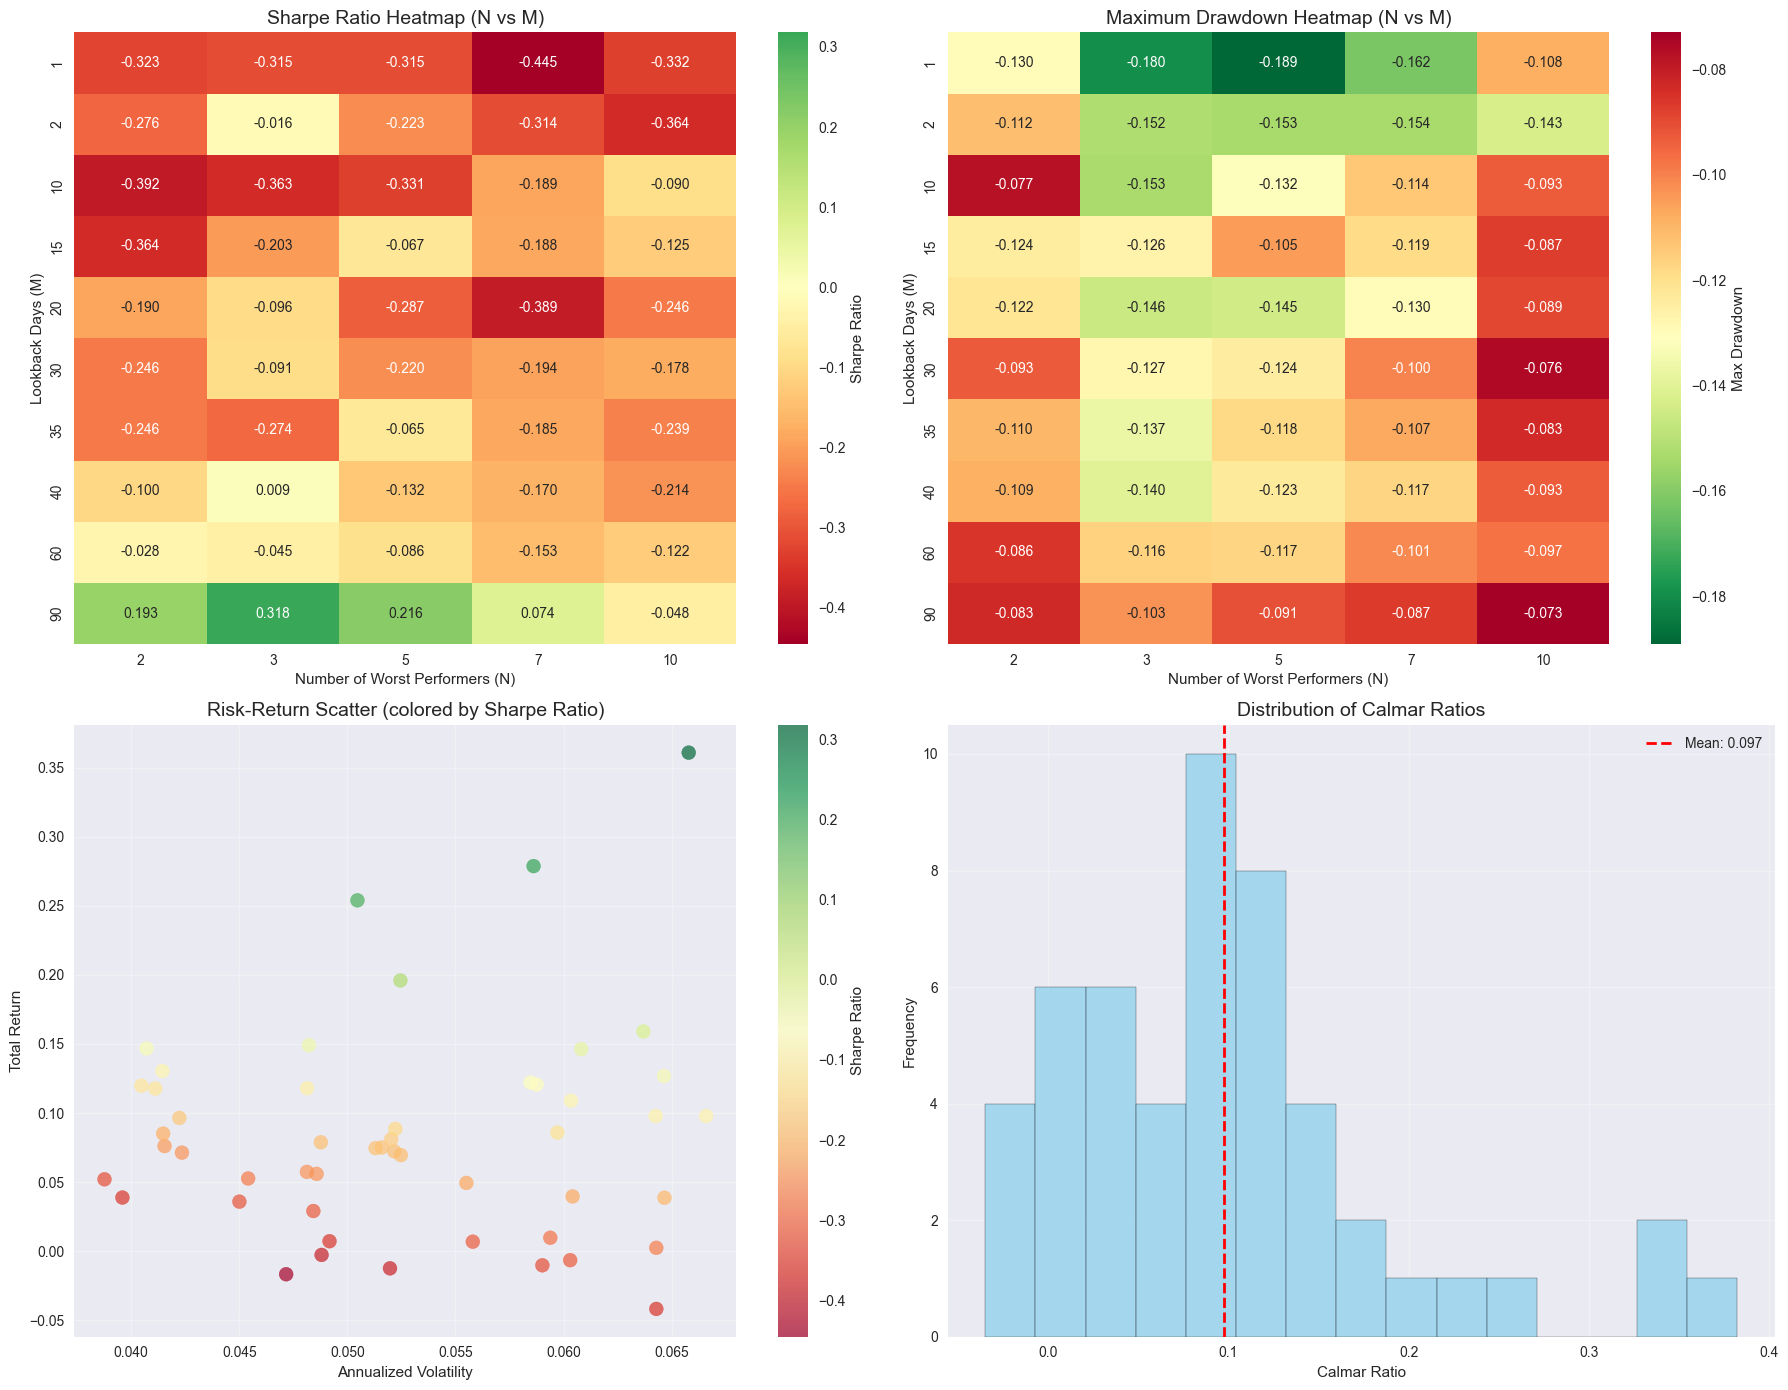

In [4]:
# Visualize parameter optimization results
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Heatmap of Sharpe ratios across parameters
pivot_sharpe = optimization_results.pivot(index='lookback_days', 
                                          columns='n_worst_performers', 
                                          values='val_sharpe_ratio')
sns.heatmap(pivot_sharpe, annot=True, cmap='RdYlGn', center=0, fmt='.3f', 
            cbar_kws={'label': 'Sharpe Ratio'}, ax=axes[0,0])
axes[0,0].set_title('Sharpe Ratio Heatmap (N vs M)', fontsize=14)
axes[0,0].set_xlabel('Number of Worst Performers (N)')
axes[0,0].set_ylabel('Lookback Days (M)')

# 2. Heatmap of Max Drawdown
pivot_dd = optimization_results.pivot(index='lookback_days', 
                                      columns='n_worst_performers', 
                                      values='val_max_drawdown')
sns.heatmap(pivot_dd, annot=True, cmap='RdYlGn_r', fmt='.3f', 
            cbar_kws={'label': 'Max Drawdown'}, ax=axes[0,1])
axes[0,1].set_title('Maximum Drawdown Heatmap (N vs M)', fontsize=14)
axes[0,1].set_xlabel('Number of Worst Performers (N)')
axes[0,1].set_ylabel('Lookback Days (M)')

# 3. Return vs Risk scatter
scatter = axes[1,0].scatter(optimization_results['val_volatility'], 
                            optimization_results['val_total_return'], 
                            c=optimization_results['val_sharpe_ratio'], 
                            s=100, alpha=0.7, cmap='RdYlGn')
axes[1,0].set_xlabel('Annualized Volatility')
axes[1,0].set_ylabel('Total Return')
axes[1,0].set_title('Risk-Return Scatter (colored by Sharpe Ratio)', fontsize=14)
plt.colorbar(scatter, ax=axes[1,0], label='Sharpe Ratio')
axes[1,0].grid(True, alpha=0.3)

# 4. Calmar ratio distribution
axes[1,1].hist(optimization_results['val_calmar_ratio'], bins=15, alpha=0.7, 
               edgecolor='black', color='skyblue')
axes[1,1].axvline(optimization_results['val_calmar_ratio'].mean(), color='red', 
                  linestyle='--', linewidth=2, 
                  label=f'Mean: {optimization_results["val_calmar_ratio"].mean():.3f}')
axes[1,1].set_xlabel('Calmar Ratio')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Calmar Ratios', fontsize=14)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Best Strategy Full Backtest

In [5]:
# Get best parameters and run full backtest
import time

best_params = optimization_results.loc[optimization_results['val_sharpe_ratio'].idxmax()]
best_n = int(best_params['n_worst_performers'])
best_m = int(best_params['lookback_days'])

print(f"🏆 BEST PARAMETERS: N={best_n}, M={best_m}")
print(f"Optimization period Sharpe Ratio: {best_params['val_sharpe_ratio']:.4f}")
print(f"💰 Using Transaction Cost: {TRANSACTION_COST_BPS} bps ({TRANSACTION_COST_BPS/100:.3f}%) per trade")
print("\n🔬 Running full historical backtest with best parameters...")

# Initialize components with best parameters
signal_generator = ConrarianSignalGenerator(
    n_worst_performers=best_n, 
    lookback_days=best_m
)

portfolio_manager = PortfolioManager(
    volatility_method='ewma',
    risk_parity_method='erc',
    target_volatility=0.12,
    max_position_size=0.3
)

# Use the same transaction costs as in optimization
backtesting_engine = BacktestingEngine(
    transaction_cost_bps=TRANSACTION_COST_BPS,  # Use the same costs as optimization
    initial_capital=1000000
)

# Time the signal generation
print("📊 Generating contrarian signals...")
start_time = time.time()
signal_output = signal_generator.generate_signals(prices, returns)
signal_time = time.time() - start_time
print(f"   ✅ Signal generation completed in {signal_time:.2f} seconds")

# Time the portfolio management
print("⚖️ Applying risk parity portfolio management...")
start_time = time.time()
portfolio_results = portfolio_manager.run_portfolio_management(signal_output, returns)
portfolio_time = time.time() - start_time
print(f"   ✅ Portfolio management completed in {portfolio_time:.2f} seconds")

# Time the backtesting
print("🎯 Executing comprehensive backtest...")
start_time = time.time()
backtest_results = backtesting_engine.run_backtest(
    portfolio_results['portfolio_weights'], 
    returns, 
    start_date=None,  # Full period
    end_date=None,
    use_fast_mode=True  # Enable all optimizations
)
backtest_time = time.time() - start_time
print(f"   ✅ Backtesting completed in {backtest_time:.2f} seconds")

total_time = signal_time + portfolio_time + backtest_time
print(f"\n🚀 TOTAL EXECUTION TIME: {total_time:.2f} seconds")
print("✅ Full backtest completed!")

🏆 BEST PARAMETERS: N=3, M=90
Optimization period Sharpe Ratio: 0.3183
💰 Using Transaction Cost: 0.0 bps (0.000%) per trade

🔬 Running full historical backtest with best parameters...
📊 Generating contrarian signals...
   ✅ Signal generation completed in 0.07 seconds
⚖️ Applying risk parity portfolio management...
   ✅ Portfolio management completed in 57.64 seconds
🎯 Executing comprehensive backtest...
   ✅ Backtesting completed in 0.03 seconds

🚀 TOTAL EXECUTION TIME: 57.73 seconds
✅ Full backtest completed!
   ✅ Portfolio management completed in 57.64 seconds
🎯 Executing comprehensive backtest...
   ✅ Backtesting completed in 0.03 seconds

🚀 TOTAL EXECUTION TIME: 57.73 seconds
✅ Full backtest completed!


## 4. Portfolio Performance Analysis

In [6]:
# Analyze portfolio performance
analyzer = PerformanceAnalyzer()

# Use the correct method name - analyze_returns instead of calculate_comprehensive_metrics
portfolio_metrics = analyzer.analyze_returns(backtest_results['portfolio_returns'])

print("📈 COMPREHENSIVE PORTFOLIO PERFORMANCE METRICS")
print("=" * 60)

# Check what keys are available in backtest_results
print("Available keys in backtest_results:")
print(list(backtest_results.keys()))

# Calculate portfolio values and drawdown analysis FIRST
portfolio_returns = backtest_results['portfolio_returns']
portfolio_values = 1000000 * (1 + portfolio_returns).cumprod()

# Calculate maximum drawdown manually
cumulative_returns = (1 + portfolio_returns).cumprod()
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()

# Calculate Calmar ratio manually
annualized_return = portfolio_metrics['annualized_return']
calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0

# Store the calculated metrics in portfolio_metrics
portfolio_metrics['max_drawdown'] = max_drawdown
portfolio_metrics['calmar_ratio'] = calmar_ratio

# Core performance metrics
print("\n🎯 CORE PERFORMANCE:")
print(f"Total Return:              {portfolio_metrics['total_return']:.2%}")
print(f"Annualized Return:         {portfolio_metrics['annualized_return']:.2%}")
print(f"Annualized Volatility:     {portfolio_metrics['volatility']:.2%}")
print(f"Sharpe Ratio:              {portfolio_metrics['sharpe_ratio']:.4f}")

# Risk metrics - now with properly calculated values
print("\n⚠️ RISK METRICS:")
print(f"Maximum Drawdown:          {portfolio_metrics['max_drawdown']:.2%}")
print(f"Calmar Ratio:              {portfolio_metrics['calmar_ratio']:.4f}")
print(f"Sortino Ratio:             {portfolio_metrics['sortino_ratio']:.4f}")
print(f"VaR (5%):                  {portfolio_metrics.get('VaR_5%', 0.0):.2%}")
print(f"CVaR (5%):                 {portfolio_metrics.get('CVaR_5%', 0.0):.2%}")

# Additional metrics
print("\n📊 ADDITIONAL METRICS:")
print(f"Win Rate:                  {portfolio_metrics['win_rate']:.2%}")
print(f"Profit Factor:             {portfolio_metrics['profit_factor']:.4f}")
print(f"Skewness:                  {portfolio_metrics['skewness']:.4f}")
print(f"Kurtosis:                  {portfolio_metrics['kurtosis']:.4f}")
print(f"Information Ratio:         {portfolio_metrics.get('information_ratio', 0.0):.4f}")

# Display backtest summary
print("\n📋 BACKTEST SUMMARY:")
print(f"Strategy Parameters:       N={best_n}, M={best_m}")
print(f"Number of Currencies:      {len(prices.columns)}")
print(f"Backtest Period:           {len(portfolio_returns)} days")
print(f"Transaction Cost:          {TRANSACTION_COST_BPS} bps ({TRANSACTION_COST_BPS/100:.3f}%) per trade")
print(f"Initial Capital:           $1,000,000")

# Calculate final portfolio value from returns
final_portfolio_value = 1000000 * (1 + portfolio_returns).cumprod().iloc[-1]
print(f"Final Portfolio Value:     ${final_portfolio_value:,.0f}")

# Store additional metrics for later use
portfolio_metrics['var_95'] = portfolio_metrics.get('VaR_5%', 0.0)
portfolio_metrics['cvar_95'] = portfolio_metrics.get('CVaR_5%', 0.0)
portfolio_metrics['annual_return'] = portfolio_metrics['annualized_return']
portfolio_metrics['annual_volatility'] = portfolio_metrics['volatility']
portfolio_metrics['information_ratio'] = portfolio_metrics.get('information_ratio', 0.0)

📈 COMPREHENSIVE PORTFOLIO PERFORMANCE METRICS
Available keys in backtest_results:
['portfolio_returns', 'portfolio_value', 'portfolio_weights', 'transaction_costs', 'turnover', 'drawdowns', 'rebalancing_dates', 'asset_returns', 'signals', 'metadata']

🎯 CORE PERFORMANCE:
Total Return:              58.03%
Annualized Return:         1.74%
Annualized Volatility:     8.55%
Sharpe Ratio:              0.0107

⚠️ RISK METRICS:
Maximum Drawdown:          -32.66%
Calmar Ratio:              0.0534
Sortino Ratio:             0.0009
VaR (5%):                  -0.70%
CVaR (5%):                 -1.18%

📊 ADDITIONAL METRICS:
Win Rate:                  47.39%
Profit Factor:             1.0524
Skewness:                  0.9145
Kurtosis:                  37.3655
Information Ratio:         0.0000

📋 BACKTEST SUMMARY:
Strategy Parameters:       N=3, M=90
Number of Currencies:      20
Backtest Period:           6676 days
Transaction Cost:          0.0 bps (0.000%) per trade
Initial Capital:           $1,00

## 5. Advanced Portfolio Visualizations

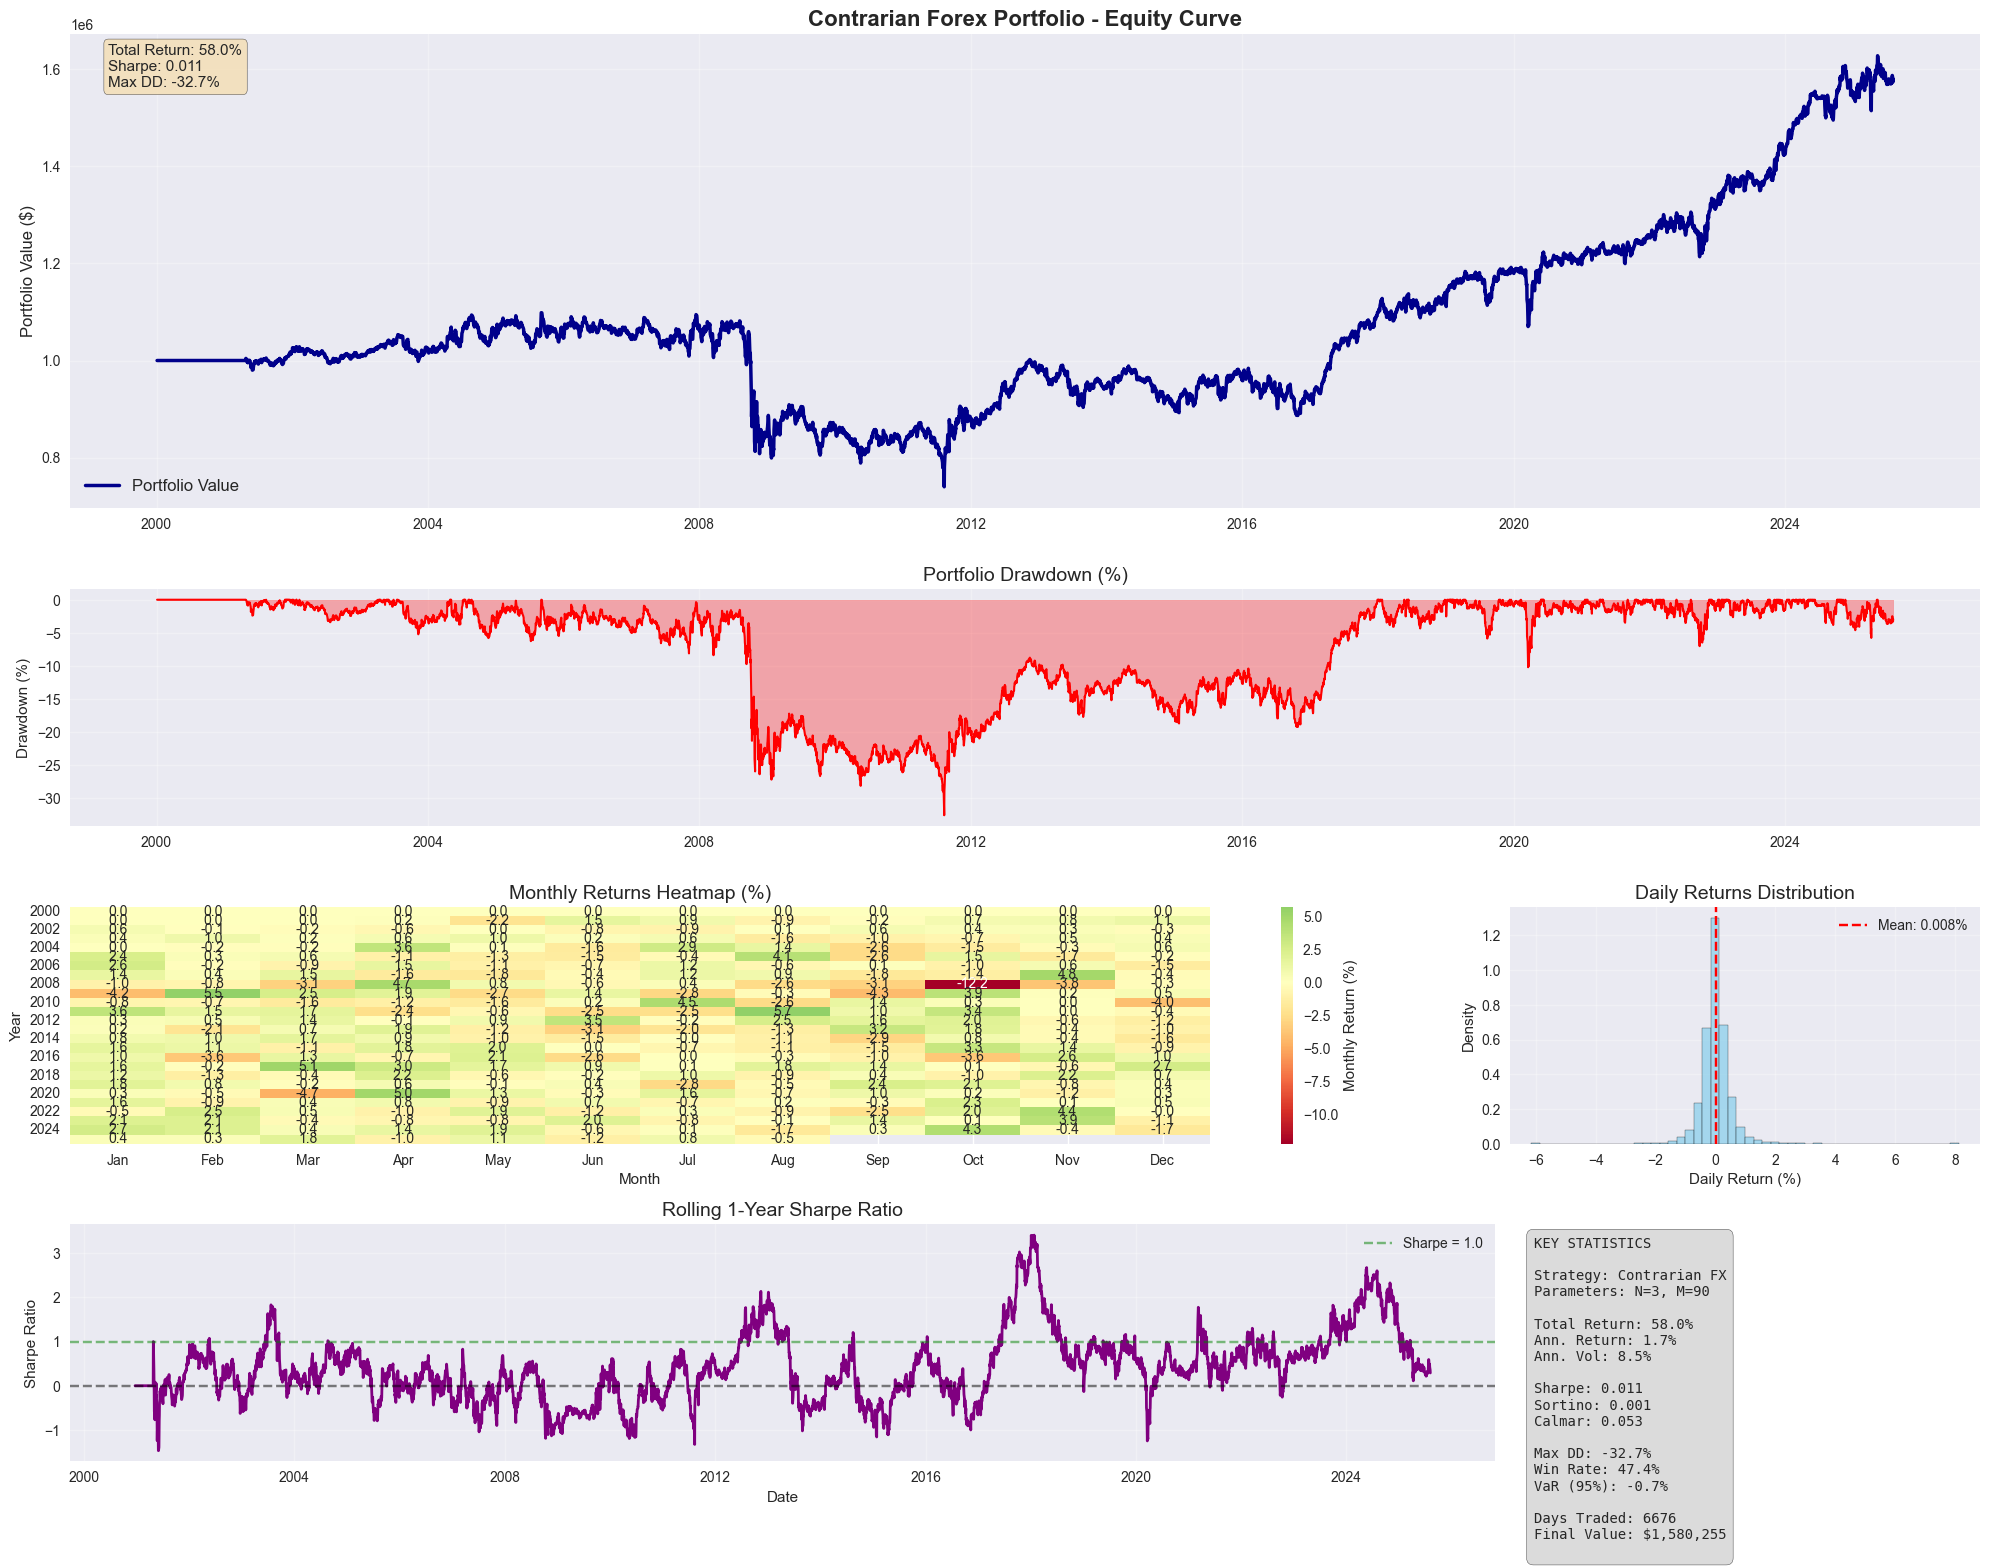

In [7]:
# Create comprehensive portfolio visualization dashboard
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, height_ratios=[2, 1, 1, 1], width_ratios=[2, 1, 1])

# Calculate portfolio values from returns
portfolio_returns = backtest_results['portfolio_returns']
portfolio_values = 1000000 * (1 + portfolio_returns).cumprod()  # Calculate from returns
dates = portfolio_returns.index

# 1. Portfolio Equity Curve (main chart)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(dates, portfolio_values, linewidth=2.5, color='darkblue', label='Portfolio Value')
ax1.set_title('Contrarian Forex Portfolio - Equity Curve', fontsize=16, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)

# Add performance annotations
final_value = portfolio_values.iloc[-1]
initial_value = portfolio_values.iloc[0]
total_return = (final_value / initial_value - 1) * 100
ax1.text(0.02, 0.98, f'Total Return: {total_return:.1f}%\nSharpe: {portfolio_metrics["sharpe_ratio"]:.3f}\nMax DD: {portfolio_metrics["max_drawdown"]:.1%}', 
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Drawdown Chart
ax2 = fig.add_subplot(gs[1, :])
cumulative_returns = (1 + portfolio_returns).cumprod()
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max * 100

ax2.fill_between(dates, drawdown, 0, color='red', alpha=0.3)
ax2.plot(dates, drawdown, color='red', linewidth=1.5)
ax2.set_title('Portfolio Drawdown (%)', fontsize=14)
ax2.set_ylabel('Drawdown (%)')
ax2.grid(True, alpha=0.3)

# 3. Monthly Returns Heatmap
ax3 = fig.add_subplot(gs[2, :2])
monthly_returns = portfolio_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_returns_pct = monthly_returns * 100

# Create monthly returns matrix
monthly_matrix = monthly_returns_pct.groupby([monthly_returns_pct.index.year, monthly_returns_pct.index.month]).first().unstack()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

if len(monthly_matrix) > 0:
    sns.heatmap(monthly_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.1f', 
                cbar_kws={'label': 'Monthly Return (%)'}, ax=ax3,
                xticklabels=month_names)
    ax3.set_title('Monthly Returns Heatmap (%)', fontsize=14)
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Year')

# 4. Return Distribution
ax4 = fig.add_subplot(gs[2, 2])
daily_returns_pct = portfolio_returns * 100
ax4.hist(daily_returns_pct, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
ax4.axvline(daily_returns_pct.mean(), color='red', linestyle='--', 
            label=f'Mean: {daily_returns_pct.mean():.3f}%')
ax4.set_title('Daily Returns Distribution', fontsize=14)
ax4.set_xlabel('Daily Return (%)')
ax4.set_ylabel('Density')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# 5. Rolling Sharpe Ratio
ax5 = fig.add_subplot(gs[3, :2])
rolling_sharpe = portfolio_returns.rolling(252).apply(
    lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0
)
ax5.plot(dates, rolling_sharpe, color='purple', linewidth=2)
ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax5.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1.0')
ax5.set_title('Rolling 1-Year Sharpe Ratio', fontsize=14)
ax5.set_xlabel('Date')
ax5.set_ylabel('Sharpe Ratio')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Key Statistics Box
ax6 = fig.add_subplot(gs[3, 2])
ax6.axis('off')
stats_text = f"""KEY STATISTICS

Strategy: Contrarian FX
Parameters: N={best_n}, M={best_m}

Total Return: {portfolio_metrics['total_return']:.1%}
Ann. Return: {portfolio_metrics['annual_return']:.1%}
Ann. Vol: {portfolio_metrics['annual_volatility']:.1%}

Sharpe: {portfolio_metrics['sharpe_ratio']:.3f}
Sortino: {portfolio_metrics['sortino_ratio']:.3f}
Calmar: {portfolio_metrics['calmar_ratio']:.3f}

Max DD: {portfolio_metrics['max_drawdown']:.1%}
Win Rate: {portfolio_metrics['win_rate']:.1%}
VaR (95%): {portfolio_metrics['var_95']:.1%}

Days Traded: {len(portfolio_returns)}
Final Value: ${final_value:,.0f}
"""

ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

## 6. Risk Analysis and Stress Testing

In [8]:
# Advanced risk analysis
print("⚠️ ADVANCED RISK ANALYSIS")
print("=" * 50)

# 1. Worst periods analysis
portfolio_returns = backtest_results['portfolio_returns']

# Find worst days
worst_days = portfolio_returns.nsmallest(10)
print("\n📉 TOP 10 WORST DAYS:")
for date, return_val in worst_days.items():
    print(f"{date.strftime('%Y-%m-%d')}: {return_val:.2%}")

# Find worst months
monthly_rets = portfolio_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
worst_months = monthly_rets.nsmallest(10)
print("\n📉 TOP 10 WORST MONTHS:")
for date, return_val in worst_months.items():
    print(f"{date.strftime('%Y-%m')}: {return_val:.2%}")

# 2. Stress test scenarios
print("\n🧪 STRESS TEST SCENARIOS:")
print("-" * 30)

# Market crash simulation (2008-2009 period)
crisis_start = '2008-01-01'
crisis_end = '2009-12-31'
crisis_mask = (portfolio_returns.index >= crisis_start) & (portfolio_returns.index <= crisis_end)
crisis_returns = portfolio_returns[crisis_mask]

if len(crisis_returns) > 0:
    crisis_total_return = (1 + crisis_returns).prod() - 1
    crisis_sharpe = crisis_returns.mean() / crisis_returns.std() * np.sqrt(252)
    crisis_max_dd = ((1 + crisis_returns).cumprod() / (1 + crisis_returns).cumprod().expanding().max() - 1).min()
    
    print(f"2008-2009 Financial Crisis:")
    print(f"  Total Return: {crisis_total_return:.2%}")
    print(f"  Sharpe Ratio: {crisis_sharpe:.3f}")
    print(f"  Max Drawdown: {crisis_max_dd:.2%}")

# High volatility periods
rolling_vol = portfolio_returns.rolling(30).std() * np.sqrt(252)
high_vol_threshold = rolling_vol.quantile(0.9)
high_vol_periods = portfolio_returns[rolling_vol > high_vol_threshold]

print(f"\nHigh Volatility Periods (>90th percentile):")
print(f"  Average Return: {high_vol_periods.mean():.3%} daily")
print(f"  Win Rate: {(high_vol_periods > 0).mean():.1%}")
print(f"  Number of Days: {len(high_vol_periods)}")

# Tail risk analysis
print(f"\n📊 TAIL RISK ANALYSIS:")
returns_pct = portfolio_returns * 100
print(f"1st Percentile: {np.percentile(returns_pct, 1):.2f}%")
print(f"5th Percentile: {np.percentile(returns_pct, 5):.2f}%")
print(f"95th Percentile: {np.percentile(returns_pct, 95):.2f}%")
print(f"99th Percentile: {np.percentile(returns_pct, 99):.2f}%")

# Expected Shortfall
var_95 = np.percentile(portfolio_returns, 5)
es_95 = portfolio_returns[portfolio_returns <= var_95].mean()
print(f"Expected Shortfall (95%): {es_95:.2%}")

⚠️ ADVANCED RISK ANALYSIS

📉 TOP 10 WORST DAYS:
2008-10-15: -6.15%
2008-10-24: -6.11%
2008-10-06: -6.03%
2008-10-08: -4.60%
2008-10-10: -4.05%
2008-11-20: -3.89%
2008-12-01: -3.78%
2008-11-12: -3.76%
2025-04-07: -3.40%
2008-09-29: -3.35%

📉 TOP 10 WORST MONTHS:
2008-10: -12.23%
2020-03: -4.70%
2009-09: -4.26%
2009-01: -4.16%
2010-12: -4.04%
2008-11: -3.78%
2016-02: -3.58%
2016-10: -3.56%
2008-03: -3.13%
2008-09: -3.10%

🧪 STRESS TEST SCENARIOS:
------------------------------
2008-2009 Financial Crisis:
  Total Return: -19.51%
  Sharpe Ratio: -0.471
  Max Drawdown: -26.12%

High Volatility Periods (>90th percentile):
  Average Return: 0.084% daily
  Win Rate: 51.9%
  Number of Days: 665

📊 TAIL RISK ANALYSIS:
1st Percentile: -1.33%
5th Percentile: -0.70%
95th Percentile: 0.72%
99th Percentile: 1.47%
Expected Shortfall (95%): -1.18%


## 7. Portfolio Composition Analysis

In [9]:
# Analyze portfolio composition over time
portfolio_weights = portfolio_results['portfolio_weights']
signal_binary = signal_output['binary_signals']  # FIXED: Use signal_output dict

print("💼 PORTFOLIO COMPOSITION ANALYSIS")
print("=" * 50)

# Calculate selection frequency for each currency
selection_freq = signal_binary.mean().sort_values(ascending=False)
print("\n🎯 CURRENCY SELECTION FREQUENCY:")
for currency, freq in selection_freq.items():
    print(f"{currency.replace('_X', ''):<10}: {freq:.1%}")

# Calculate average weights when selected
avg_weights_when_selected = {}
for currency in portfolio_weights.columns:
    selected_mask = signal_binary[currency] == 1
    if selected_mask.sum() > 0:
        avg_weight = portfolio_weights[currency][selected_mask].mean()
        avg_weights_when_selected[currency] = avg_weight

avg_weights_series = pd.Series(avg_weights_when_selected).sort_values(ascending=False)
print("\n⚖️ AVERAGE WEIGHT WHEN SELECTED:")
for currency, weight in avg_weights_series.items():
    print(f"{currency.replace('_X', ''):<10}: {weight:.1%}")

💼 PORTFOLIO COMPOSITION ANALYSIS

🎯 CURRENCY SELECTION FREQUENCY:
USDCHF    : 21.2%
USDJPY    : 21.1%
EURGBP    : 20.5%
NZDUSD    : 18.9%
AUDCHF    : 17.7%
AUDUSD    : 16.1%
GBPNZD    : 15.3%
AUDJPY    : 15.3%
EURNZD    : 15.3%
USDCAD    : 14.2%
GBPAUD    : 12.7%
EURUSD    : 11.9%
EURAUD    : 11.5%
EURCAD    : 11.2%
GBPJPY    : 10.5%
GBPCHF    : 10.2%
GBPCAD    : 9.8%
EURJPY    : 8.9%
GBPUSD    : 8.2%
EURCHF    : 5.7%

⚖️ AVERAGE WEIGHT WHEN SELECTED:
EURGBP    : 47.5%
EURCHF    : 37.5%
USDJPY    : 37.4%
USDCAD    : 36.4%
EURUSD    : 36.1%
GBPAUD    : 34.9%
USDCHF    : 34.6%
GBPUSD    : 34.5%
GBPCHF    : 34.3%
EURCAD    : 33.4%
GBPCAD    : 33.3%
EURAUD    : 33.1%
AUDUSD    : 32.7%
GBPJPY    : 31.8%
EURNZD    : 31.6%
AUDCHF    : 31.3%
NZDUSD    : 31.1%
EURJPY    : 30.9%
GBPNZD    : 30.7%
AUDJPY    : 28.3%


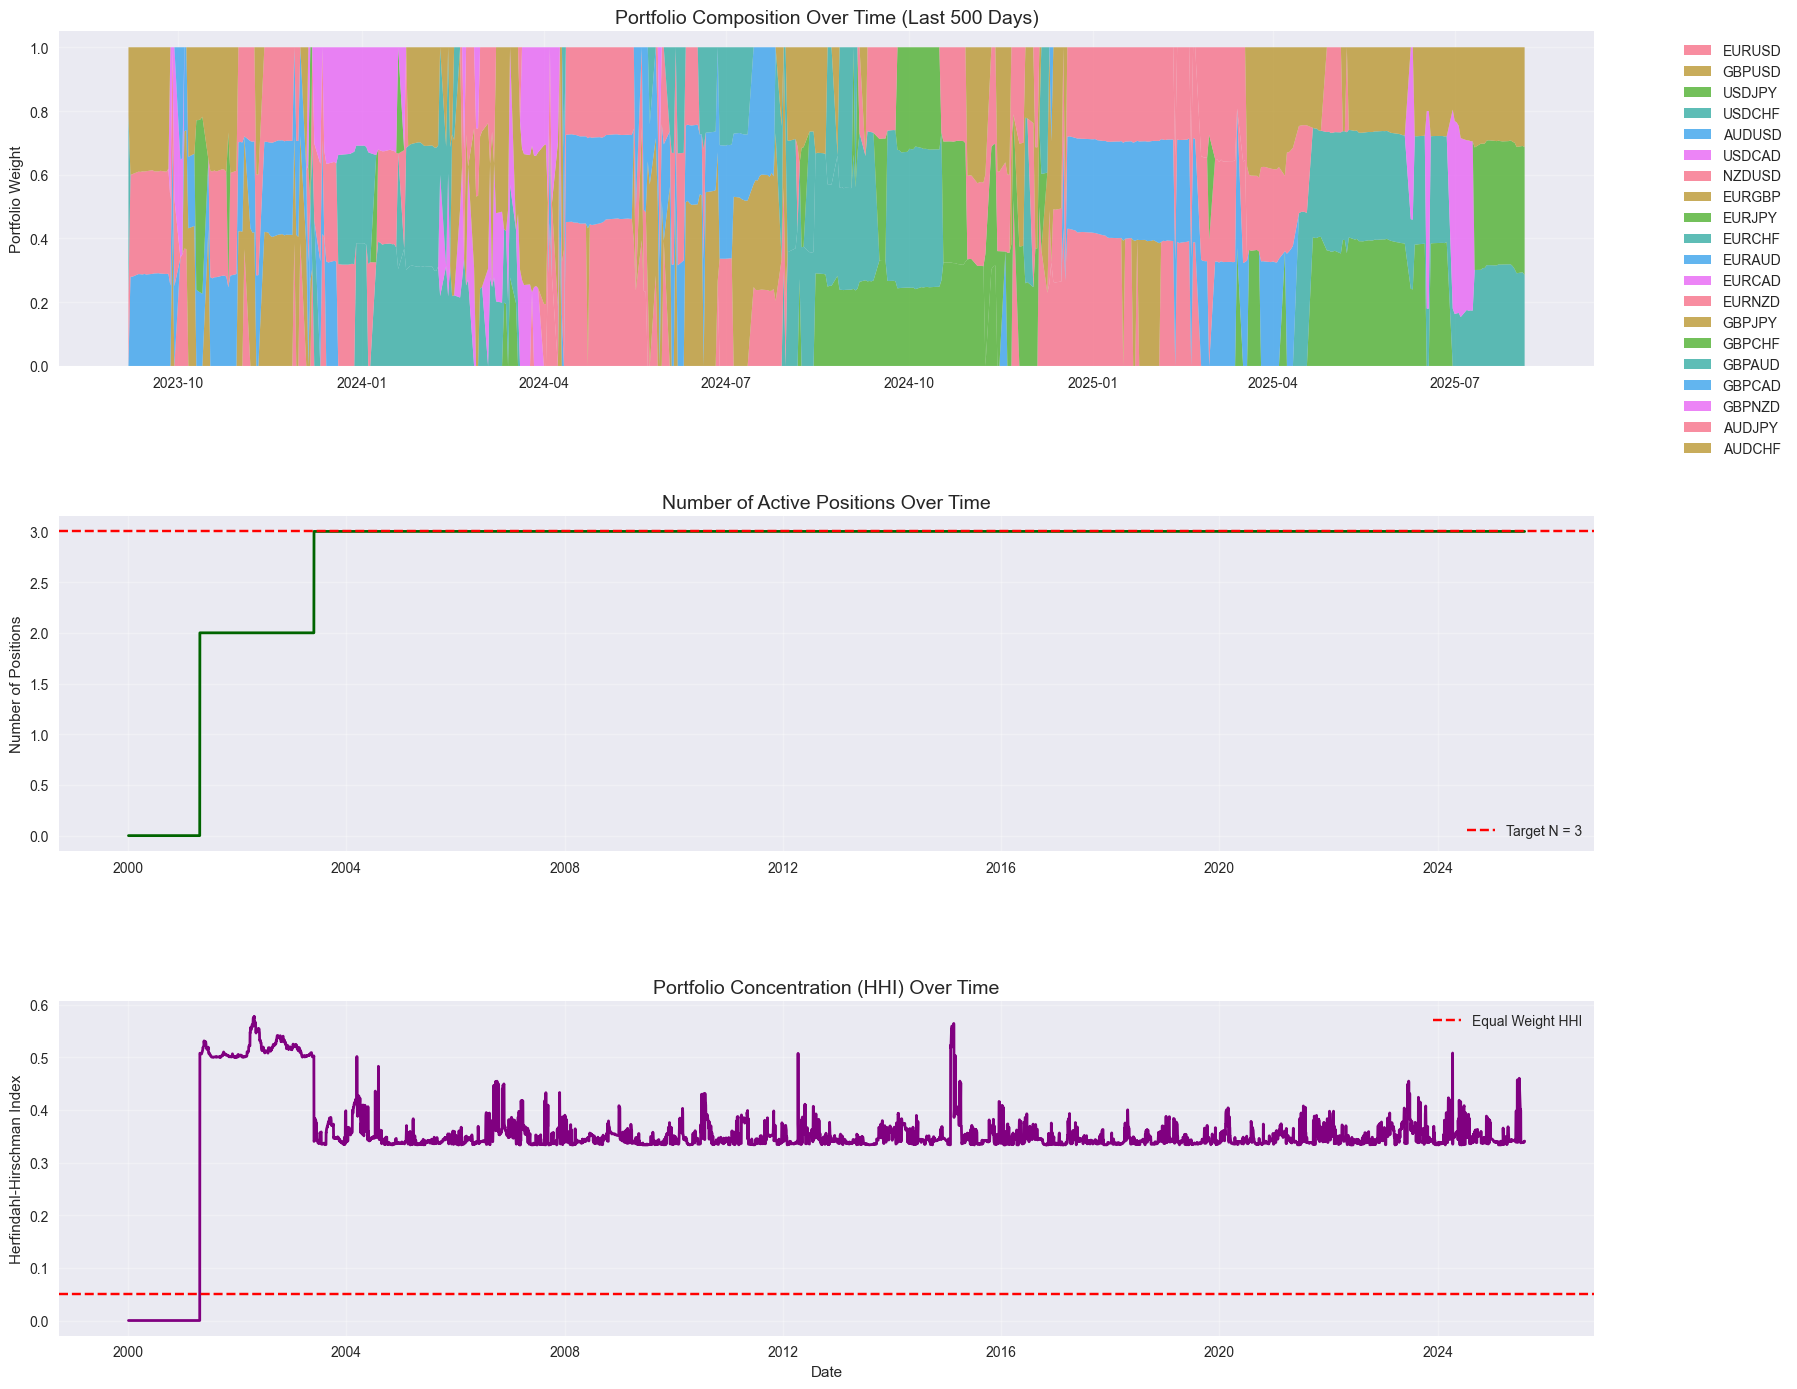

In [10]:
# Visualize portfolio composition over time
fig, axes = plt.subplots(3, 1, figsize=(18, 14))

# 1. Portfolio weights stacked area chart (last 500 days for clarity)
recent_weights = portfolio_weights.tail(500)
recent_dates = recent_weights.index

# Only show currencies that were selected at least once in recent period
active_currencies = recent_weights.columns[recent_weights.sum() > 0]
recent_weights_active = recent_weights[active_currencies]

axes[0].stackplot(recent_dates, *[recent_weights_active[col] for col in recent_weights_active.columns], 
                  labels=[col.replace('_X', '') for col in recent_weights_active.columns], alpha=0.8)
axes[0].set_title('Portfolio Composition Over Time (Last 500 Days)', fontsize=14)
axes[0].set_ylabel('Portfolio Weight')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)

# 2. Number of positions over time
num_positions = (portfolio_weights > 0.001).sum(axis=1)  # Positions > 0.1%
axes[1].plot(num_positions.index, num_positions, color='darkgreen', linewidth=2)
axes[1].axhline(y=best_n, color='red', linestyle='--', 
                label=f'Target N = {best_n}')
axes[1].set_title('Number of Active Positions Over Time', fontsize=14)
axes[1].set_ylabel('Number of Positions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Portfolio concentration (HHI) over time
portfolio_hhi = (portfolio_weights ** 2).sum(axis=1)
axes[2].plot(portfolio_hhi.index, portfolio_hhi, color='purple', linewidth=2)
axes[2].axhline(y=1/len(prices.columns), color='red', linestyle='--', 
                label='Equal Weight HHI')
axes[2].set_title('Portfolio Concentration (HHI) Over Time', fontsize=14)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Herfindahl-Hirschman Index')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Benchmark Comparison and Alpha Analysis

📊 BENCHMARK COMPARISON ANALYSIS

🏆 BENCHMARK COMPARISON TABLE:


,Total Return,Annual Return,Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
Contrarian Portfolio,0.5803,0.0174,0.0855,0.0107,-0.3266,0.0534
Equal Weight,0.3563,0.0116,0.0636,-0.1040,-0.2017,0.0574
Best Single (AUDUSD),-0.1559,-0.0085,1.1062,0.1632,-0.8743,-0.0097


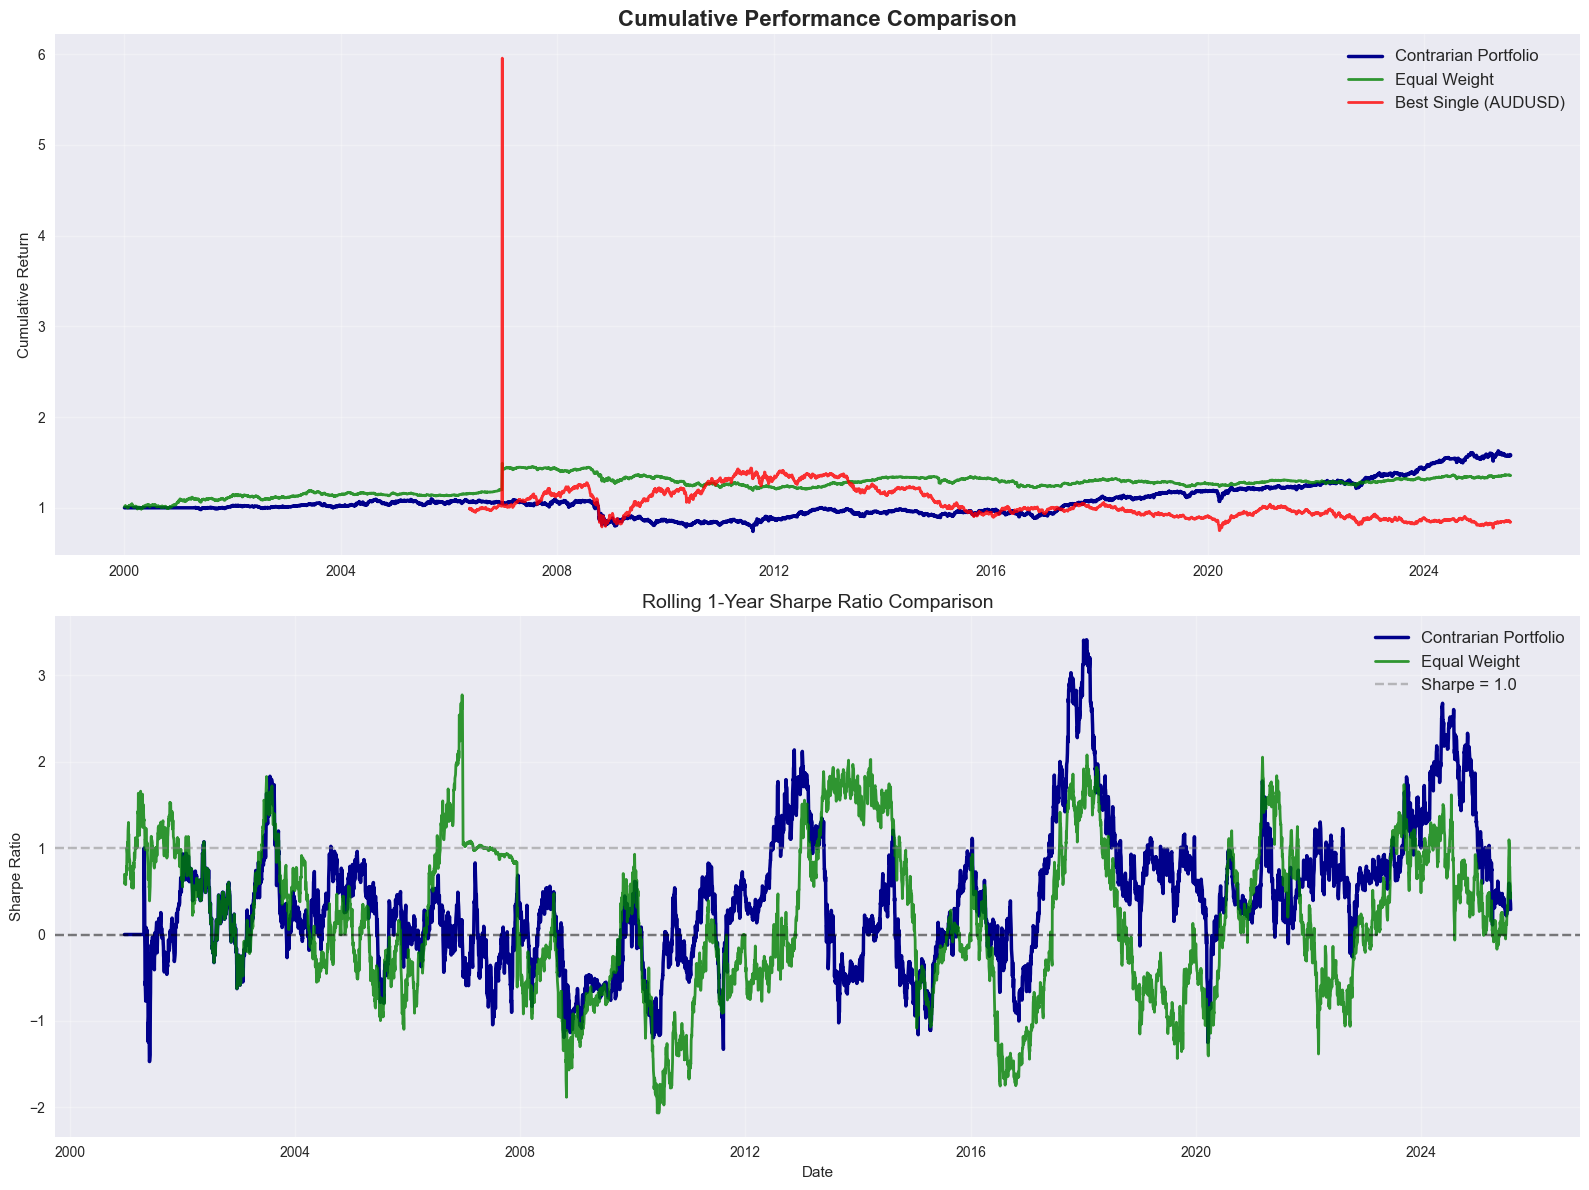

In [11]:
# Create benchmark comparisons
print("📊 BENCHMARK COMPARISON ANALYSIS")
print("=" * 50)

# Equal weight benchmark
equal_weight_returns = returns.mean(axis=1)  # Simple equal weight
equal_weight_cumulative = (1 + equal_weight_returns).cumprod()

# Buy and hold best performer benchmark
best_single_currency = returns.mean().idxmax()
best_single_returns = returns[best_single_currency]
best_single_cumulative = (1 + best_single_returns).cumprod()

# Portfolio cumulative returns
portfolio_cumulative = (1 + portfolio_returns).cumprod()

# Calculate benchmark metrics using the correct method name
benchmarks = {
    'Contrarian Portfolio': portfolio_returns,
    'Equal Weight': equal_weight_returns,
    f'Best Single ({best_single_currency.replace("_X", "")})': best_single_returns
}

benchmark_metrics = {}
for name, returns_series in benchmarks.items():
    # Use analyze_returns instead of calculate_comprehensive_metrics
    metrics = analyzer.analyze_returns(returns_series)
    
    # Calculate drawdown manually for each benchmark
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()
    calmar = metrics['annualized_return'] / abs(max_dd) if max_dd < 0 else 0.0
    
    benchmark_metrics[name] = {
        'Total Return': metrics['total_return'],
        'Annual Return': metrics['annualized_return'],  # Use correct key
        'Volatility': metrics['volatility'],
        'Sharpe Ratio': metrics['sharpe_ratio'],
        'Max Drawdown': max_dd,  # Use calculated value
        'Calmar Ratio': calmar   # Use calculated value
    }

benchmark_df = pd.DataFrame(benchmark_metrics).T
print("\n🏆 BENCHMARK COMPARISON TABLE:")
display(benchmark_df.round(4))

# Plot benchmark comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Cumulative performance comparison
ax1.plot(portfolio_cumulative.index, portfolio_cumulative, 
         label='Contrarian Portfolio', linewidth=2.5, color='darkblue')
ax1.plot(equal_weight_cumulative.index, equal_weight_cumulative, 
         label='Equal Weight', linewidth=2, color='green', alpha=0.8)
ax1.plot(best_single_cumulative.index, best_single_cumulative, 
         label=f'Best Single ({best_single_currency.replace("_X", "")})', 
         linewidth=2, color='red', alpha=0.8)

ax1.set_title('Cumulative Performance Comparison', fontsize=16, fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Rolling Sharpe comparison
rolling_window = 252  # 1 year
portfolio_rolling_sharpe = portfolio_returns.rolling(rolling_window).apply(
    lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0)
equal_weight_rolling_sharpe = equal_weight_returns.rolling(rolling_window).apply(
    lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0)

ax2.plot(portfolio_rolling_sharpe.index, portfolio_rolling_sharpe, 
         label='Contrarian Portfolio', linewidth=2.5, color='darkblue')
ax2.plot(equal_weight_rolling_sharpe.index, equal_weight_rolling_sharpe, 
         label='Equal Weight', linewidth=2, color='green', alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Sharpe = 1.0')

ax2.set_title('Rolling 1-Year Sharpe Ratio Comparison', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sharpe Ratio')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Final Summary and Recommendations

In [12]:
print("\n📈 STRATEGY OVERVIEW:")
print(f"Strategy Type:           Contrarian Mean Reversion")
print(f"Asset Universe:          {len(prices.columns)} Major & Cross Currency Pairs")
print(f"Optimal Parameters:      N={best_n} worst performers, M={best_m} day lookback")
print(f"Portfolio Method:        Risk Parity (ERC) with Volatility Targeting")
print(f"Rebalancing:             Daily")
print(f"Transaction Costs:       {TRANSACTION_COST_BPS} bps ({TRANSACTION_COST_BPS/100:.3f}%) per trade")


📈 STRATEGY OVERVIEW:
Strategy Type:           Contrarian Mean Reversion
Asset Universe:          20 Major & Cross Currency Pairs
Optimal Parameters:      N=3 worst performers, M=90 day lookback
Portfolio Method:        Risk Parity (ERC) with Volatility Targeting
Rebalancing:             Daily
Transaction Costs:       0.0 bps (0.000%) per trade
